In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 16.8 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=7ba19996c25149d0c0a69250138d27f56710a0b4bffde02b0b5040faf854d9d1
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as LA
from pyspark import SparkContext
import os

In [ ]:
def calculate_cost(row, centers):
    ith, (d, n) = row
    distance = LA.norm(d - centers[ith], 2)
    return distance**2

In [ ]:
def mapper(line):
    lines = line.split(' ')
    list_lines = [float(x) for x in lines]
    return np.array(list_lines)

In [ ]:
def nearest_center(row, centers):
    distance = [(i, LA.norm(row - center, 2)) for i, center in enumerate(centers)]
    distance.sort(key=lambda k: k[-1])
    return (distance[0][0], (row, 1))

In [ ]:
def plot_cost(c1_cost, c2_cost):
    x = range(1, len(c1_cost) + 1)

    plt.title('Cost for c1 & c2', fontsize=15)
    plt.xlabel('Iterations', fontsize=15)
    plt.ylabel('Cost', fontsize=15)
    plt.plot(x, c1_cost, color='orange', linewidth=2.0, linestyle='-',label="c1_cost")
    plt.plot(x, c2_cost, color='blue', linewidth=2.0, linestyle='-',label="c2_cost")
    plt.legend(loc='upper right')
    plt.show()


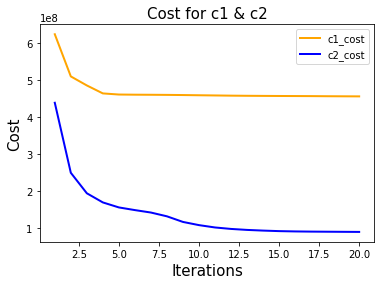

Percentage change in cost after 10 iterations using c1 is:
0.2648391714456056 

Percentage change in cost after 10 iterations using c2 is:
0.7669795594605946 



In [ ]:
if __name__ == '__main__':

    loops = 20

    sc = SparkContext.getOrCreate()
    path = 'data.txt'
    data = sc.textFile(path).map(lambda row:mapper(row)).cache()
    path1 = 'c1.txt'
    c1 = sc.textFile(path1).map(lambda row:mapper(row)).collect()
    path2 = 'c2.txt'
    c2 = sc.textFile(path2).map(lambda row:mapper(row)).collect()

    c1_cost = []
    c2_cost = []

    for i in range(loops):
        kmeans_c1 = data.map(lambda row: nearest_center(row, c1))
        cost1 = kmeans_c1.map(lambda row: calculate_cost(row, c1)).sum()
        c1_cost.append(cost1)
        c1 = kmeans_c1.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])).map(lambda row: row[-1][0] / row[-1][1]).collect()

        kmeans_c2 = data.map(lambda row: nearest_center(row, c2))
        cost2 = kmeans_c2.map(lambda row: calculate_cost(row, c2)).sum()
        c2_cost.append(cost2)
        c2 = kmeans_c2.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])).map(lambda row: row[-1][0] / row[-1][1]).collect()

    plot_cost(c1_cost, c2_cost)

    print('Percentage change in cost after 10 iterations using c1 is:')
    print((c1_cost[0]-c1_cost[10])/c1_cost[0], '\n')

    print('Percentage change in cost after 10 iterations using c2 is:')
    print((c2_cost[0]-c2_cost[10])/c2_cost[0], '\n')